### 1. Parse and prepare the data
- import the datasets for facebook, gdp and regions
- remove the countries excluded due to low penetration
- prepare the data for xgboost

### 2. Train XGBoost

### 3. Calculate Shapley values

# 1. PARSE AND PREPARE THE DATA

In [7]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

directory = "./data/"


In [8]:
# countries to exclude

to_keep = pd.read_excel(directory+"to_keep.xlsx")
cnt_keep = list(to_keep.Country)
len(cnt_keep)

115

In [10]:
# facebook data
df = pd.read_excel(directory+"Jun_Veg_Fractions_revision.xlsx")
df = df[df['country'].isin(cnt_keep)]
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [82]:
df_drop = pd.read_excel(directory+"Jun_Veg_Fractions.xlsx")
df_drop = df_drop[~df_drop['country'].isin(cnt_keep)]
df_drop = df_drop.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [86]:
df_drop.head()

,ages_ranges,genders,scholarities,geo_locations,dau_audience,mau_audience,age_min,country,age_max,interest_name,interest_ids,dau_per,mau_per
78,65-65+,male,College grad,BJ,0,1000,65,Benin,NaN,Vegetarianism,6003155333705L 6003341096108L,0.0,0.138889
79,65-65+,male,High school grad,BJ,0,1000,65,Benin,NaN,Vegetarianism,6003155333705L 6003341096108L,0.0,0.769231
80,65-65+,male,Doctorate degree,BJ,0,1000,65,Benin,NaN,Vegetarianism,6003155333705L 6003341096108L,0.0,1.000000
81,65-65+,male,Professional degree,BJ,0,1000,65,Benin,NaN,Vegetarianism,6003155333705L 6003341096108L,0.0,1.000000
82,65-65+,male,In college,BJ,0,1000,65,Benin,NaN,Vegetarianism,6003155333705L 6003341096108L,0.0,1.000000


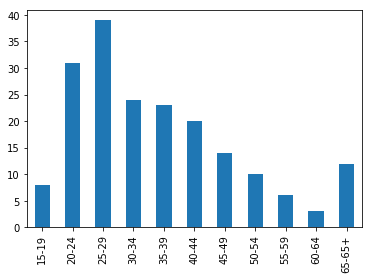

In [91]:
df_drop[df_drop['dau_per']>0.1]['ages_ranges'].value_counts().sort_index().plot(kind='bar')

cikardigim ulkelerdeki gorece yuksek vejeteryan interest'i 20 yasin uzerinde. En gec grupta epey dusuk! Bu demek oluyor ki, en dusuk yas grubunun negatif etkisini yok ettim? nooo

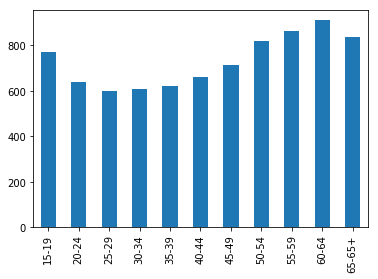

In [100]:
df[df['dau_per']<0.05]['Age cohort'].value_counts().sort_index().plot(kind='bar')

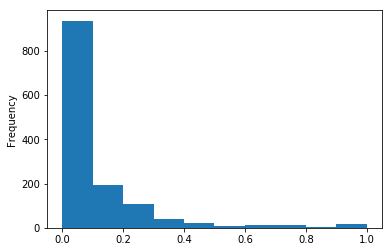

In [106]:
df[df['Age cohort']=='15-19']['dau_per'].plot(kind='hist')

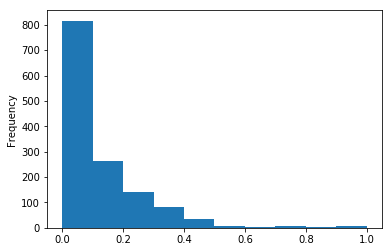

In [108]:
df[df['Age cohort']=='20-24']['dau_per'].plot(kind='hist')

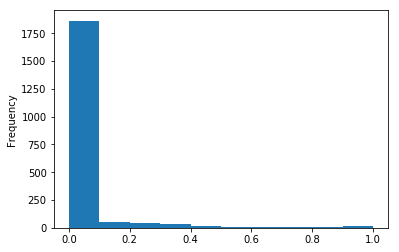

In [89]:
df_drop['dau_per'].plot(kind='hist')

In [11]:
# gdp data
df_gdp = pd.read_excel(directory+"AllData_Aggregate.xlsx")
df_gdp = df_gdp[df_gdp['Unnamed: 0'].isin(cnt_keep)]
df_gdp.set_index('Unnamed: 0', inplace=True)

In [12]:
df_regions = pd.read_csv(directory+'regions.csv')

df_regions.set_index('name', inplace=True)

as_list = df_regions.index.tolist()
idx = as_list.index('Republic of Korea')
as_list[idx] = 'South Korea'
idx = as_list.index('United States of America')
as_list[idx] = 'United States'
idx = as_list.index('Russian Federation')
as_list[idx] = 'Russia'
idx = as_list.index('U.K. of Great Britain and Northern Ireland')
as_list[idx] = 'United Kingdom'

df_regions.index = as_list

In [13]:
fb_countries = set(df['country'])
for cnt in fb_countries:
    try : 
        df.loc[df['country']==cnt, 'gdp'] = df_gdp.loc[cnt, 'GDP']
        df.loc[df['country']==cnt, 'region'] = df_regions.loc[cnt, 'region_gea']
    except KeyError as e: 
        print (e)
        pass
    

'Vietnam'
"Côte d'Ivoire"


## Prepare the data for XGBoost


In [14]:
# fix the education level
rep_dict = {'In high school' : '1-In high school',
            'High school grad' : '2-High school grad',
            'Professional degree' : '3-Professional degree',
            'In college' : '4-In college',
            'College grad' : '5-College grad', 
            'Doctorate degree' : '6-Doctorate degree'}
df=df.rename(columns = {'scholarities':'Education level',
                        'ages_ranges' : 'Age cohort',
                        'genders' : 'Gender',
                        'country' : 'Countries',
                        'gdp' : 'GDP',
                        'region' : 'Regions'})
df = df.replace(rep_dict)

In [15]:
# DROP NANS, HENCE df_na IS THE DATA WITHOUT NANs
print(df.shape)
#df_rest = df[(df['dau_per']<=.5)] 
#print(df_rest.shape)
df_na = df.dropna(axis=0)
df_na.shape

(14539, 15)


(12884, 15)

In [16]:
df_na = df_na[['Age cohort', 'Gender', 'Education level', 'Countries', 'GDP', 'Regions', 'dau_per']]


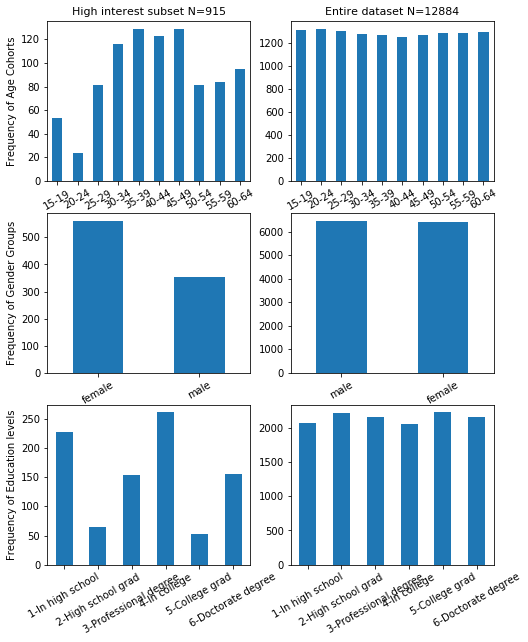

In [54]:
# what is in df_na[y>0.5]

fig, axes = plt.subplots(3,2)
fig. set_size_inches(8,10)
fig.hspace = .25
axes[0, 0] = df_na[df_na['dau_per']>0.5]['Age cohort'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title("High interest subset N=915", fontsize=11)
axes[0,0].set_ylabel("Frequency of Age Cohorts")
axes[0, 1] = df_na['Age cohort'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title("Entire dataset N=12884", fontsize=11)

axes[1, 0] = df_na[df_na['dau_per']>0.5]['Gender'].value_counts().plot(kind='bar', ax=axes[1, 0])
axes[1, 1] = df_na['Gender'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1, 0].set_ylabel("Frequency of Gender Groups")

axes[2,0] = df_na[df_na['dau_per']>0.5]['Education level'].value_counts().sort_index().plot(kind='bar', ax=axes[2,0])
axes[2,1] = df_na['Education level'].value_counts().sort_index().plot(kind='bar', ax=axes[2,1])
axes[2,0].set_ylabel("Frequency of Education levels")

for i in [0,1,2]:
    for j in [0,1]:
        axes[i,j].set_xticklabels(axes[i,j].get_xticklabels(), rotation=30)
plt.savefig(directory+"/revision1/subset_distribution.png")
plt.show()

In [58]:
# Convert string to integers to be able to run regression
from sklearn import preprocessing

#Xs = {}
#Ys = {}
#for key, df in dfs.items():
X = np.zeros(shape=(df_na.shape[0],6))
y = df_na['dau_per'].values
decoders = {}
for j,col in enumerate(['Age cohort', 'Gender', 'Education level', 'Countries', 'GDP', 'Regions']):
    decoders[col] = preprocessing.LabelEncoder()
    decoders[col].fit(df_na[col].values)
    X[:, j] = decoders[col].transform(df_na[col].values)


In [43]:
X[:,1].shape # the size of all dataset for xgb

(12884,)

# XGboost


In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import math

import xgboost

C:\Users\sibel\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\sibel\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# xgboost
learning = [0.01, 0.3, 0.5, 1]
depth = [3, 6, 9, 15]
obj = ['reg:squarederror', 'reg:logistic']
tree = ['auto', 'hist']
params = {
          'colsample_bynode': 0.8,
          'learning_rate': 0.01,
          'max_depth': 6,
          'objective': 'binary:logistic',
          'tree_method': 'hist'
        }
res_mse = {}
res_y = {}
for learn_rate in learning:
    for d in depth:
        for o in obj:
            for t in tree:
                key = (learn_rate, d, o, t)
                params['learning_rate'] = learn_rate
                params['max_depth'] = d
                params['objective'] = o
                params['tree_method'] = t
                model = xgboost.train(params, xgboost.DMatrix(X_train, label=y_train))
                y_test_pred = model.predict(xgboost.DMatrix(X_test))
                mse = mean_squared_error(y_test_pred, y_test)
                res_mse[key] = mse
                res_y[key] = y_test_pred


res_mse = {k: v for k, v in sorted(res_mse.items(), key=lambda item: item[1])}

In [23]:
# make a df for the seaborn joint plot with the first two rmse

df_mse = pd.DataFrame(columns=['test data', 'test prediction', 'mse'])
df_mse['test data'] = y_test
#x_scatter = y_test
k1 = list(res_mse.keys())[0] 

df_mse['test prediction'] = res_y[k1]
df_mse['mse'] = 'model 1 mse={0:.4f}'.format(res_mse[k1])

# add the 2nd rank
k2 = list(res_mse.keys())[1] 
df_mse = df_mse.append(pd.DataFrame({'test data' : y_test,
                        'test prediction': res_y[k2],
                        'mse' : 'model 2 mse={0:.4f}'.format(res_mse[k2])}), ignore_index=True)




In [15]:
df_mse.tail()

,test data,test prediction,mse
6437,0.000000,0.046033,mse=0.040961
6438,0.178659,0.248253,mse=0.040961
6439,0.371202,0.320608,mse=0.040961
6440,1.000000,0.076111,mse=0.040961
6441,0.000000,0.121179,mse=0.040961


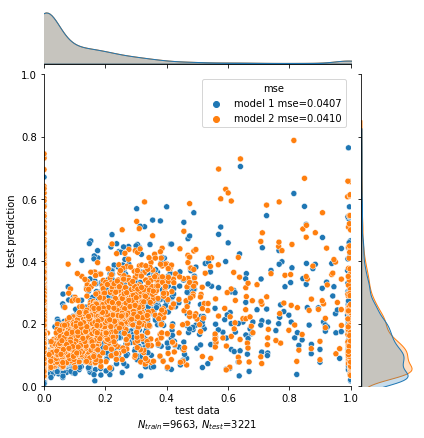

In [28]:
g = sns.jointplot(data=df_mse, x="test data", y="test prediction", hue="mse")
g.ax_marg_x.set_xlim(0, 1)
g.ax_marg_y.set_ylim(0, 1)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
xlab = "test data\n$N_{train}$="+str(ntrain)+", $N_{test}$="+str(ntest)
g.ax_joint.set_xlabel(xlab)

plt.savefig(directory+'test-train_revision.png', dpi=300,)
plt.show()

In [25]:
k1

(0.5, 9, 'reg:logistic', 'auto')

In [29]:
k2

(0.3, 15, 'reg:logistic', 'auto')

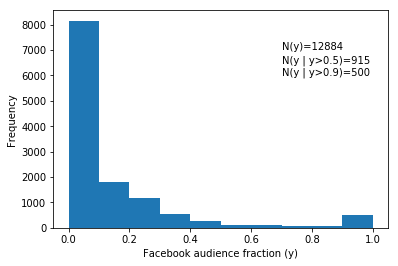

In [130]:
ax = pd.DataFrame(y).plot(kind='hist', legend=False)
ax.set_xlabel("Facebook audience fraction (y)")
ax.annotate("N(y)={}".format(len(y)), (0.7, 7000))
ax.annotate("N(y | y>0.5)={}".format(len(y[y>0.5])), (0.7, 6500))
ax.annotate("N(y | y>0.9)={}".format(len(y[y>0.9])), (0.7, 6000))
plt.savefig(directory+"revision1/entire_distribution.png")

In [128]:
y[y>0.5].shape

(915,)

### Training XGBoost for y<1

In [131]:
#y1 = y[y.round(decimals=1)<1]
#X1= X[y.round(decimals=1)<1, :]
y1 = y[y>0.5]
X1 = X[y>0.5]
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1)

In [132]:
y.shape

(12884,)

In [133]:
y1.shape

(915,)

In [134]:
y1.max()

1.0

In [135]:
# xgboost
learning = [0.01, 0.3, 0.5, 1]
depth = [3, 6, 9, 15]
obj = ['reg:squarederror', 'reg:logistic']
tree = ['auto', 'hist']
params = {
          'colsample_bynode': 0.8,
          'learning_rate': 0.01,
          'max_depth': 6,
          'objective': 'binary:logistic',
          'tree_method': 'hist'
        }
res_mse1 = {}
res_y1 = {}
for learn_rate in learning:
    for d in depth:
        for o in obj:
            for t in tree:
                key = (learn_rate, d, o, t)
                params['learning_rate'] = learn_rate
                params['max_depth'] = d
                params['objective'] = o
                params['tree_method'] = t
                model = xgboost.train(params, xgboost.DMatrix(X_train1, label=y_train1))
                y_test_pred1 = model.predict(xgboost.DMatrix(X_test1))
                mse = mean_squared_error(y_test_pred1, y_test1)
                res_mse1[key] = mse
                res_y1[key] = y_test_pred1


res_mse1 = {k: v for k, v in sorted(res_mse1.items(), key=lambda item: item[1])}

In [136]:
df_mse1 = pd.DataFrame(columns=['test data', 'test prediction', 'mse'])
df_mse1['test data'] = y_test1
#x_scatter = y_test
k1 = list(res_mse1.keys())[0] 

df_mse1['test prediction'] = res_y1[k1]
df_mse1['mse'] = 'model 1 mse={0:.4f}'.format(res_mse1[k1])

# add the 2nd rank
k2 = list(res_mse1.keys())[1] 
df_mse1 = df_mse1.append(pd.DataFrame({'test data' : y_test1,
                        'test prediction': res_y1[k2],
                        'mse' : 'model 2 mse={0:.4f}'.format(res_mse1[k2])}), ignore_index=True)

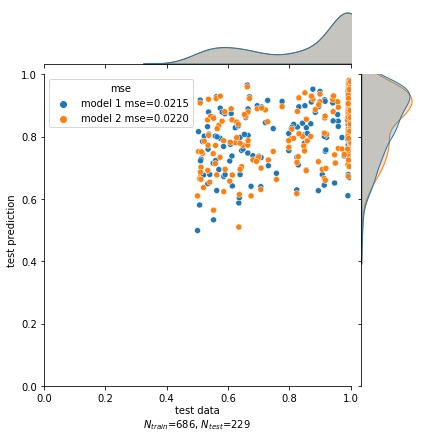

In [137]:
g = sns.jointplot(data=df_mse1, x="test data", y="test prediction", hue="mse")
g.ax_marg_x.set_xlim(0, 1)
g.ax_marg_y.set_ylim(0, 1)

ntrain = X_train1.shape[0]
ntest = X_test1.shape[0]
xlab = "test data\n$N_{train}$="+str(ntrain)+", $N_{test}$="+str(ntest)
g.ax_joint.set_xlabel(xlab)

plt.savefig(directory+'revision1test-train_revision_y05.png', dpi=300,)
plt.show()

In [57]:
# y>0.5 training paramters:
#print(k1)

(0.3, 15, 'reg:squarederror', 'auto')


In [124]:
# y<1 training paramters:
print(k1)

(0.5, 15, 'reg:logistic', 'auto')


# Shapely for well-trained XGB on the main dataset

In [63]:
import shap

In [59]:
cols = ['Age cohort', 'Gender', 'Education level', 'Countries', 'GDP', 'Regions']

In [64]:
# set to the optimal parameters of xgb training for the whole dataset
params = {
          'colsample_bynode': 0.8,
          'learning_rate': 0.5,
          'max_depth': 9,
          'objective': 'reg:logistic',
          'tree_method': 'auto'
        }


cols = ['Age cohort', 'Gender', 'Education level', 'Countries', 'GDP', 'Regions']

# using the X and y
X_train, X_test, y_train, y_test = train_test_split(X, y)
xnew = pd.DataFrame(X, columns=cols)
model = xgboost.train(params, xgboost.DMatrix(xnew, label=y))

model_bytearray = model.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

model.save_raw = myfun

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(xnew)


In [62]:
df_shap = pd.DataFrame(shap_values)
df_shap.to_excel(directory+"shap_veg_wholedataset_revision.xlsx")

In [56]:
df_shap = pd.read_excel(directory+"revision1/shap_veg_wholedataset_revision.xlsx")

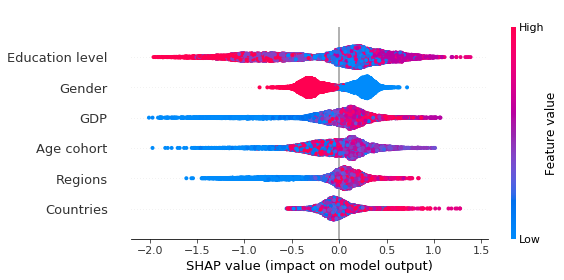

In [133]:

shap.summary_plot(shap_values, xnew, feature_names=cols, 
                  show=False, )
plt.savefig(directory+"revision1/fig4b_withoutcolorbars.png", dpi=300, bbox_inches='tight')

In [66]:
a_ages = X[:, 0]
#a = dfs['junv']['Education level'].values
a_ages = list(set(a_ages))
a_ages = np.array(a_ages, dtype=np.int8)
b_ages = decoders['Age cohort'].inverse_transform(y=a_ages)
print(a_ages)
print(b_ages)

[0 1 2 3 4 5 6 7 8 9]
['15-19' '20-24' '25-29' '30-34' '35-39' '40-44' '45-49' '50-54' '55-59'
 '60-64']


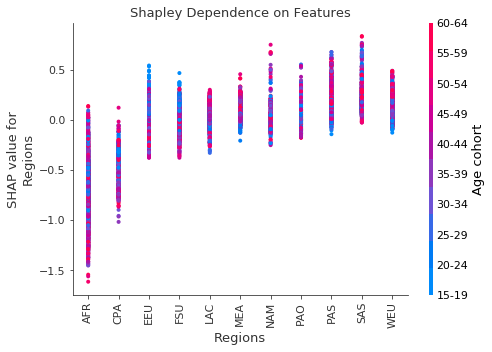

In [77]:
shap.dependence_plot('Regions', shap_values, X, feature_names=cols, interaction_index='Age cohort', 
                             show=False, title="Shapley Dependence on Features",
                            display_features=display_features,
                            )

## Main text figure for shapley values

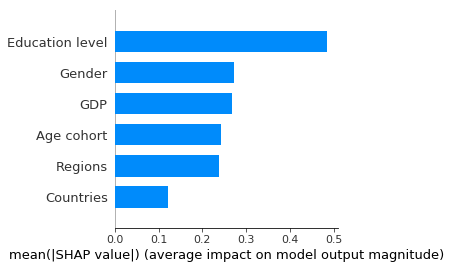

In [135]:
# Fig a
shap.summary_plot(shap_values, xnew, feature_names=cols, plot_type='bar',
                 show=False, plot_size=(4, 4))
plt.savefig(directory+"Fig4a.png", dpi=300, bbox_inches='tight')

In [111]:
a_regions = X[:, -1]
a_regions = list(set(a_regions))
a_regions = np.array(a_regions, dtype=np.int8)
b_regions = decoders['Regions'].inverse_transform(y=a_regions)
print(a_regions)
print(b_regions)

[ 0  1  2  3  4  5  6  7  8  9 10]
['AFR' 'CPA' 'EEU' 'FSU' 'LAC' 'MEA' 'NAM' 'PAO' 'PAS' 'SAS' 'WEU']


In [128]:
#['Age cohort', 'Gender', 'Education level', 'Countries', 'GDP', 'Regions']):

a_ed = X[:, 2]
a_ed = list(set(a_ed))
a_ed = np.array(a_ed, dtype=np.int8)
b_ed = decoders['Education level'].inverse_transform(y=a_ed)

a_gen = X[:, 1]
a_gen = list(set(a_gen))
a_gen = np.array(a_gen, dtype=np.int8)
b_gen = decoders['Gender'].inverse_transform(y=a_gen)

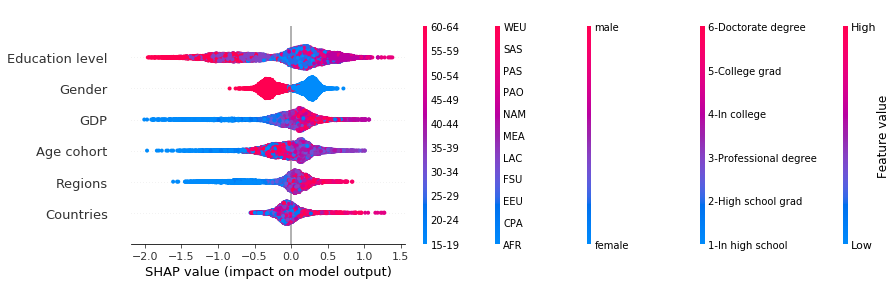

In [132]:
from matplotlib.colors import Normalize
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shap.plots import colors

shap.summary_plot(shap_values, xnew, feature_names=cols, 
                  show=False, plot_size=(15, 4))


import matplotlib.cm as cm
m = cm.ScalarMappable(cmap=colors.red_blue)

#education colorbar
m = cm.ScalarMappable(cmap=colors.red_blue)
m.set_array(a_ed[::-1])
cb_ed = plt.colorbar(m, ticks=a_ed[::-1], aspect=50)
cb_ed.set_ticklabels(b_ed[::-1])

cb_ed.ax.tick_params(labelsize=10, length=0)
cb_ed.set_alpha(1)
cb_ed.outline.set_visible(False)
cb_ed.ax.tick_params(labelsize=10) 

#gender colorbar
m = cm.ScalarMappable(cmap=colors.red_blue)
m.set_array(a_gen[::-1])
cb_gen = plt.colorbar(m, ticks=a_gen[::-1], aspect=50)
cb_gen.set_ticklabels(b_gen[::-1])

cb_gen.ax.tick_params(labelsize=10, length=0)
cb_gen.set_alpha(1)
cb_gen.outline.set_visible(False)
cb_gen.ax.tick_params(labelsize=10) 

#regions colorbar
m = cm.ScalarMappable(cmap=colors.red_blue)
m.set_array(a_regions[::-1])
cb_reg = plt.colorbar(m, ticks=a_regions[::-1], aspect=50)
cb_reg.set_ticklabels(b_regions[::-1])

cb_reg.ax.tick_params(labelsize=10, length=0)
cb_reg.set_alpha(1)
cb_reg.outline.set_visible(False)
cb_reg.ax.tick_params(labelsize=10) 

#ages colorbar
m = cm.ScalarMappable(cmap=colors.red_blue)
m.set_array(a_ages[::-1])
cb_age = plt.colorbar(m, ticks=a_ages[::-1], aspect=50)
cb_age.set_ticklabels(b_ages[::-1])

cb_age.ax.tick_params(labelsize=10, length=0)
cb_age.set_alpha(1)
cb_age.outline.set_visible(False)
cb_age.ax.tick_params(labelsize=10) 





plt.savefig(directory+"revision1/Fig4b_withcolorbars.png", dpi=300, bbox_inches='tight')
plt.show()

In [70]:
display_features = []
for i,feature in enumerate(cols):
    #x = X[:,i].astype(int)
    x = xnew.loc[:,feature].astype(int)
    a = decoders[feature].inverse_transform(y=x)
    display_features.append(a)
display_features = np.array(display_features).T

inti = {'Age cohort' : ['Education level', 'Gender', 'GDP', 'Regions'],
        'Gender' : ['Age cohort', 'Education level', 'GDP', 'Regions'],
        'Education level' : ['Age cohort', 'Gender', 'GDP', 'Regions'],
        'Countries' : ['Gender', 'Regions'],
        'Regions' : ['GDP', 'Gender', 'Education level', 'Age cohort'],
        'GDP' : ['Gender']
       }


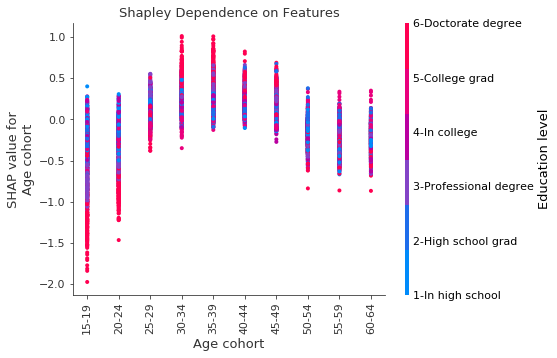

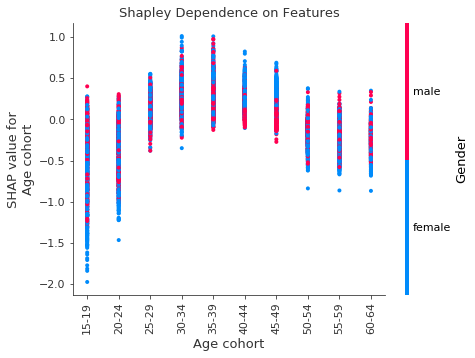

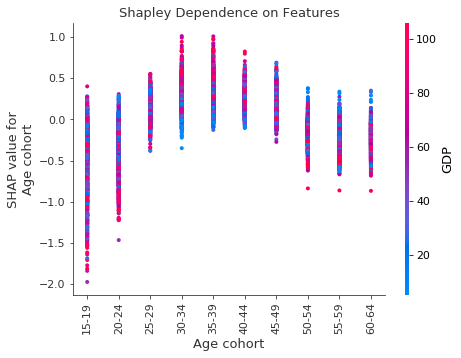

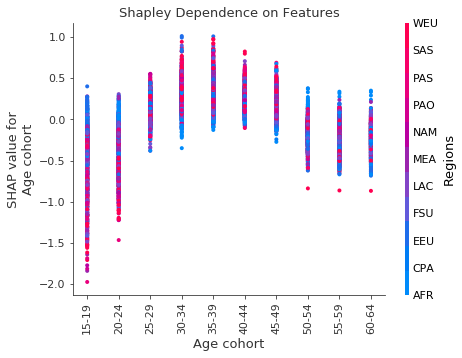

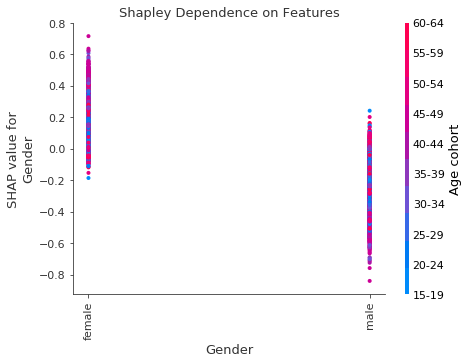

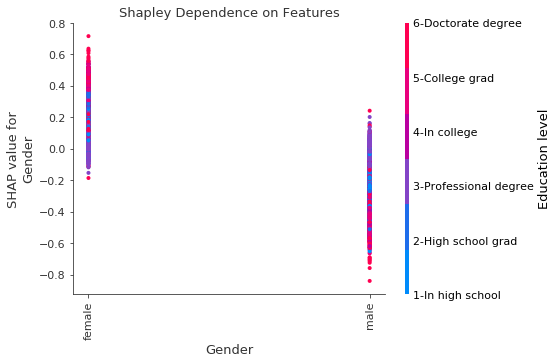

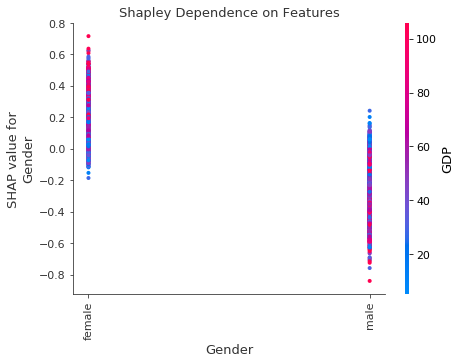

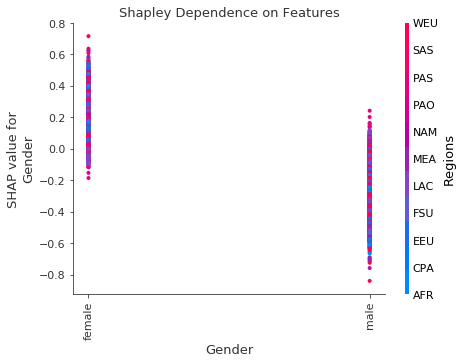

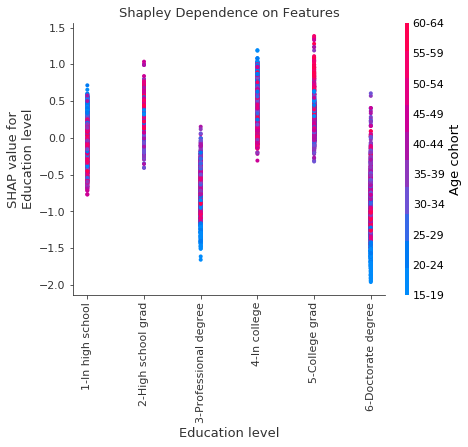

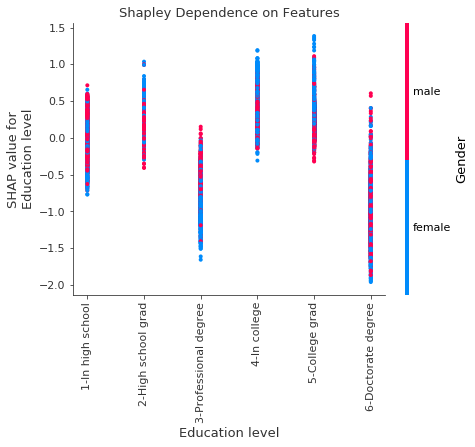

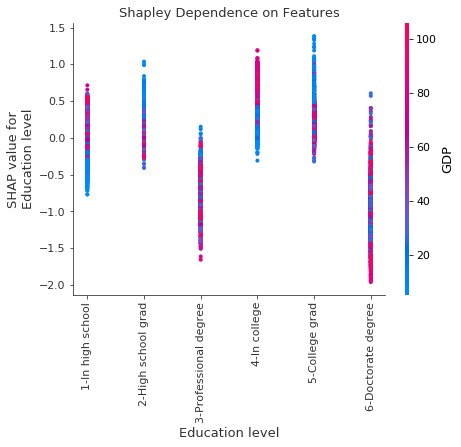

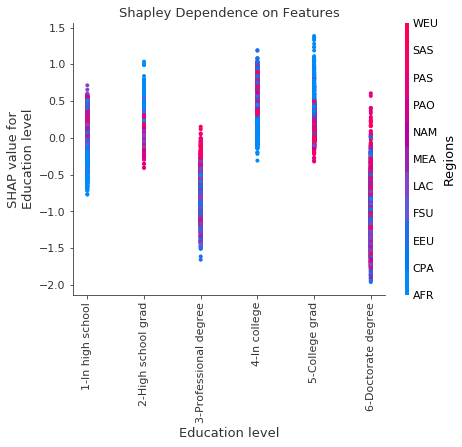

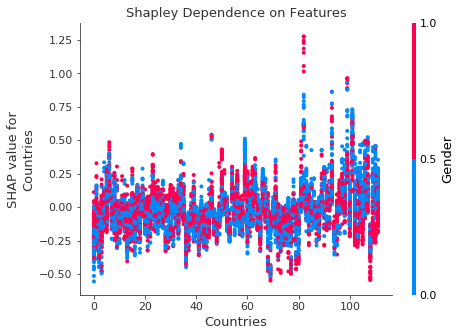

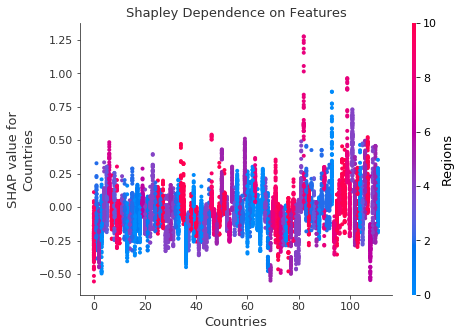

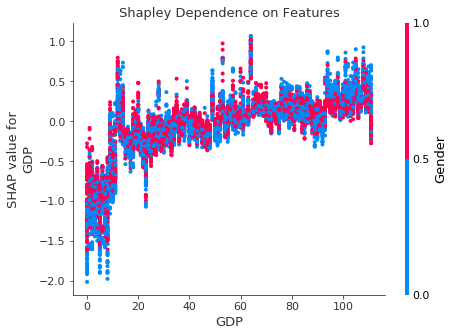

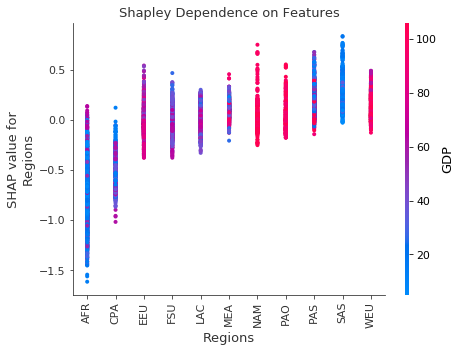

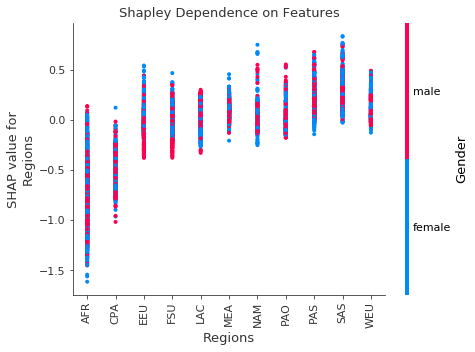

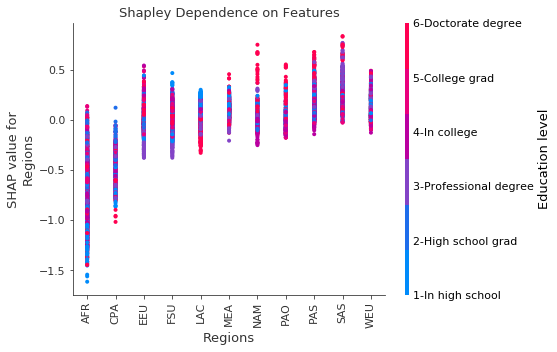

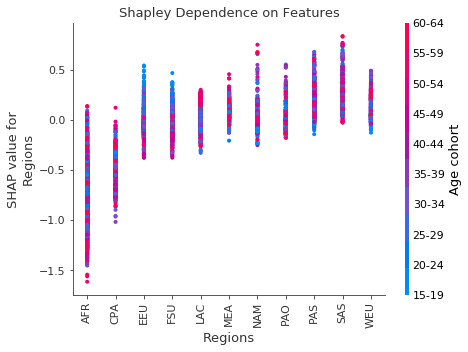

In [73]:
#shap_xgb = df_shap_xgb['juns'].values

for i,feature in enumerate(cols):
    for intindex in inti[feature]:
        fig, ax = plt.subplots(figsize=(7,5))
        #plt.subplots_adjust(wspace=.5)
        if feature not in ['Countries', 'GDP']:
            dispf = display_features
        else:
            dispf = None

        shap.dependence_plot(feature, shap_values, X, feature_names=cols, interaction_index=intindex,
                             ax=ax, 
                             show=False, title="Shapley Dependence on Features",
                            display_features=dispf,
                            )

        plt.savefig(directory+"Dependence_plots_{}_{}_revision.png".format(feature, intindex), dpi=300, bbox_inches='tight')

# Shapely for well-trained XGB on the dataset of y>0.5

In [75]:
# using the parameters in k1: 0.3, 15, 'reg:squarederror', 'auto'
params = {
          'colsample_bynode': 0.8,
          'learning_rate': 0.3,
          'max_depth': 15,
          'objective': 'reg:squarederror',
          'tree_method': 'auto'
        }


# using the X1 and y1
X_train, X_test, y_train, y_test = train_test_split(X1, y1)
xnew_subset = pd.DataFrame(X1, columns=cols)
model = xgboost.train(params, xgboost.DMatrix(xnew_subset, label=y1))

model_bytearray = model.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

model.save_raw = myfun

explainer = shap.TreeExplainer(model)

shap_values_subset = explainer.shap_values(xnew_subset)

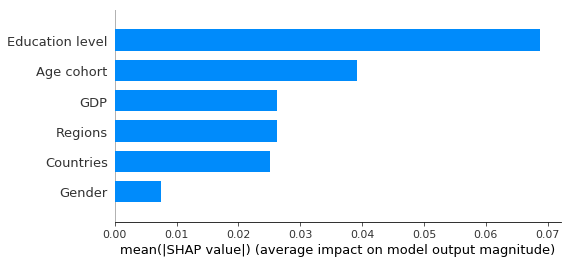

In [77]:
df_shap_subset = pd.DataFrame(shap_values_subset)
shap.summary_plot(shap_values_subset, xnew_subset, feature_names=cols, plot_type='bar',
                 show=False)
plt.savefig(directory+"Fig4a_subset.png", dpi=300, bbox_inches='tight')

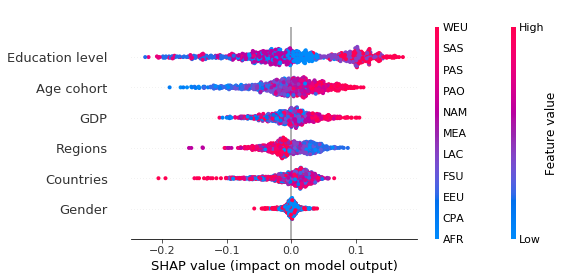

In [78]:
shap.summary_plot(shap_values_subset, xnew_subset, feature_names=cols, 
                  show=False)

m = cm.ScalarMappable(cmap=colors.red_blue)

#regions colorbar
m.set_array(a_regions[::-1])
cb = plt.colorbar(m, ticks=a_regions[::-1], aspect=50)
cb.set_ticklabels(b_regions[::-1])

cb.ax.tick_params(labelsize=11, length=0)
cb.set_alpha(1)
cb.outline.set_visible(False)
cb.ax.tick_params(labelsize=11) 

plt.savefig(directory+"Fig4b_subset.png", dpi=300, bbox_inches='tight')
plt.show()